The main article (free access):
https://doi.org/10.1103/PhysRevResearch.5.043062

## Model details

The dynamics of the driven-dissipative spatially extendend exciton-polariton condensate (under incoherent driving) is described by the following model.
It consists of two coupled equations for the condensate complex order parametner $\psi(x, t)$ and the real reservoir density $n_R(x, t)$, aka generalized stochastic  Gross-Pitaevskii equation.

\begin{align}
     i\hbar \partial_t &\psi(x, t)= 
     \Big[\epsilon(\hat{k}) + g|\psi(x, t)|^2 + 2g_Rn_R(x,t) +  \frac{i \hbar}{2}\left( R n_R(x,t) - \gamma(\hat{k}) \right) \Big]\psi(x,t) + \hbar \eta(x, t)
\label{eq:sGPE}\\
 \partial_t &n_R(x, t) = P(x)- \left(\gamma_R + R|\psi(x,t)|^2\right)n_R(x, t)
    \label{eq:reservoir}
\end{align}

 with $\hat{k}=-i\partial_x$. See the main article for the physical meaning and values of the parameters involved.

### Tunable parameters:
 - reduced pump $p = P / P_{th}$, unitless number
 - interaction energy with reservoir $\mu_{th} = 2 g_R n_{R,0}$ (in practice tuned by varying $g_R$, at fixed $n_{R,0}=\gamma_0/R$), measured in meV
 - noise strength $\sigma$, measured with respect to its nominal value $\sigma_0 = \gamma_0$


## Simulations via the condensate class

Here, some examples on the use of the 'condensate' custom class are given. It is initialized by specifying the paramenters of the model and the spatial configuration, and contains the methods for simulating the time evolution following the generalized Gross-Pitaevskii equation, or to compute the Bogoliubov spectrum at for the given set parameter.

In [1]:
# Python modules
import numpy as np
import os 
from scipy.fftpack import fft, fft2, fftfreq, fftshift
import matplotlib.pyplot as plt

# custom consensate class
import code_simulations.condensate as condensate

# Function that builds an instance of the 'condensate' class, simplified to only depend on the parameters:
# - Nx (nb of lattice sites)
# - p (reduced pump)
# - mu (interaction energy, in meV)
# - eta (multiplicative factor for the noise strength, i.e. sigma = eta * sigma_0)
# Note that all the other parameters were kept fixed in the context of this paper

def condensate_call(Nx, p, mu, eta):
    ep = condensate.condensate(N=Nx, eta=0.1, noise_type='fixed', p=p, N_spot=88, N_sig=5, pump_type='homo', 
                                   mass=1.0, dispersion_type='cos', 
                                   gam_0=1.0, gam_2=1.0, gam_type='par', R=1.0, gam_R=1.0, mu_th=mu, g=0, 
                                   psi_in='statio')
    return ep

### Temporal evolution

shape of psi(t, x): (Nt, Nx) =  (700, 64)


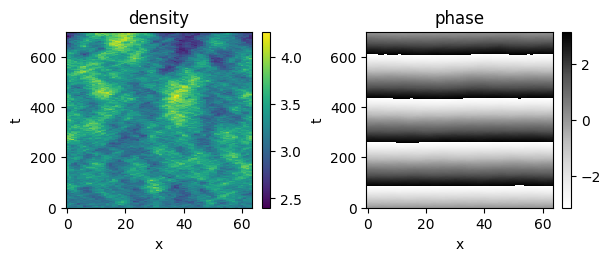

avg density: 3.332
stationary value from mean-field: 3.166


In [6]:
# condensate parameters:
Nx = 64   # nb of space points (the lattice size is fixed by default)
p = 1.12  # reduced pump, p>1 for condensate
mu = 0.15  # reservoir-mediated interaction energy (meV) (g=0 by default)
eta = 0.5 # noise prefactor (sigma = eta * sigma_0 )

x = np.arange(Nx) # dimless space grid

# build condensate 'ep'
ep = condensate_call(Nx, p, mu, eta)

# parameters of time evolution
dt = 0.1                         # time step
t_sim = 700                       # total simulation time (ps)
t_sample = 10 * dt               # time separation of sampling instants
t = np.arange(0, t_sim, t_sample)   # array of sampled instants

# simulate evolution 
# note: the initial psi(x, t=0) is set by default to sqrt{rho0}, the stationary value from mean-field)
psi = ep.Evolution(t_sim, dt, int(t_sample / dt), save_time=True, reservoir_evolution='RK4')

print('shape of psi(t, x): (Nt, Nx) = ', psi.shape)
rho = np.abs(psi)**2  # density 
phase = np.angle(psi) # compact phase

# plot space-time dynamics
fig, ax = plt.subplots(1, 2, figsize=(6, 2.5), layout='constrained')
ax[0].set_title('density')
s0 = ax[0].pcolormesh(x, t, rho)
fig.colorbar(s0, ax=ax[0])
ax[1].set_title('phase')
s1 = ax[1].pcolormesh(x, t, phase, cmap='Greys')
fig.colorbar(s1, ax=ax[1])
for axx in ax:
    axx.set_xlabel('x')
    axx.set_ylabel('t')
plt.show()

print('avg density: {:.3f}'.format(np.mean(rho)))
print('stationary value from mean-field: {:.3f}'.format(ep.rho))

### saving density of the reservoir

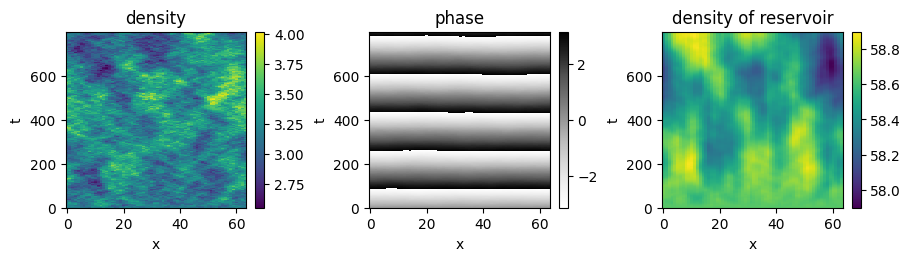

In [8]:
# simulation with reservoir
ep = condensate_call(Nx, p, mu, eta)

# parameters of time evolution
dt = 0.1                         # time step
t_sim = 800                       # total simulation time (ps)
t_sample = 10 * dt               # time separation of sampling instants
t = np.arange(0, t_sim, t_sample)   # array of sampled instants

# use ep.Evolition_nR to save the dynamics of the reservoir density nR(t, x)
psi, nR = ep.Evolution_nR(t_sim, dt, int(t_sample / dt), save_time=True, reservoir_evolution='RK4')

rho = np.abs(psi)**2  # density 
phase = np.angle(psi) # compact phase

# plot space-time dynamics
fig, ax = plt.subplots(1, 3, figsize=(9, 2.5), layout='constrained')

ax[0].set_title('density')
s0 = ax[0].pcolormesh(x, t, rho)
fig.colorbar(s0, ax=ax[0])

ax[1].set_title('phase')
s1 = ax[1].pcolormesh(x, t, phase, cmap='Greys')
fig.colorbar(s1, ax=ax[1])

ax[2].set_title('density of reservoir')
s2 = ax[2].pcolormesh(x, t, nR)
fig.colorbar(s2, ax=ax[2])

for axx in ax:
    axx.set_xlabel('x')
    axx.set_ylabel('t')
plt.show()


### Bogoliubov spectrum

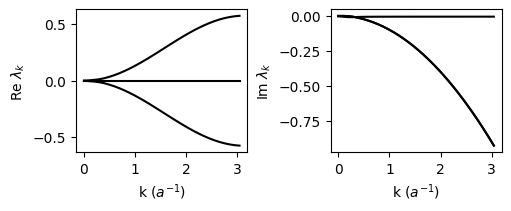

In [4]:
# condensate parameters:
Nx = 64   # nb of space points (the lattice size is fixed by default)
p = 1.12  # reduced pump, p>1 for condensate
mu = 0.15  # reservoir-mediated interaction energy (meV) (g=0 by default)
eta = 0.5 # noise prefactor (sigma = eta * sigma_0 )

x = np.arange(Nx) # dimless space grid

# build condensate 'ep'
ep = condensate_call(Nx, p, mu, eta)

# get Bogoliubov spectrum
Bog = ep.Bogoliubov(Nx) # for Nx momentum modes (can be any)
k, l1, l2, l3 = Bog

fig, ax = plt.subplots(1, 2, figsize=(5, 2), layout='constrained')

for l in [l1, l2, l3]:
    ax[0].plot(k, np.real(l), c ='k')
    ax[1].plot(k, np.imag(l), c ='k')

ax[0].set_xlabel(r'k ($a^{-1}$)')
ax[0].set_ylabel(r'Re $\lambda_k$')
ax[1].set_xlabel(r'k ($a^{-1}$)')
ax[1].set_ylabel(r'Im $\lambda_k$')

plt.show()